<h1 style = "text-align: center; color: #FFA500;">Fintech Credit Scoring Model</h1>

`Overview`

This project develops a credit scoring model using Logistic Regression to predict loan defaults, leveraging a Kaggle dataset ("Credit Risk Dataset"). Achieving a 0.76 accuracy on both cross-validation and test sets, it demonstrates robust generalization for fintech applications, such as in Nigeria's informal economy.

`Methodology`

`Data Preprocessing:` Handled missing values with mean imputation and encoded categorical variables (e.g., 'person_home_ownership', 'loan_intent') using one-hot encoding.

`Class Imbalance:` Applied SMOTE (Synthetic Minority Over-sampling Technique) to balance the minority 'default' class, ensuring the model learns from both repaid and defaulted loans effectively.

`Modeling:` Used Logistic Regression with class_weight='balanced' for fair prediction, achieving stable 0.76 accuracy.

`Feature Importance:` Visualized coefficients to identify key predictors like 'loan_int_rate' and 'person_income'.

`Results`

Accuracy: 0.76 (CV: 0.76 ± 0.00, Test: 0.76), indicating strong performance.
Visualization: Plots show feature importance and the trend of default probability vs. income, aiding interpretable decision-making.

`Design Thinking Approach (Architecture Background)`

Drawing from my B.Sc. in Architecture (Enugu State University of Science and Technology, 2020), I applied design thinking by iteratively refining the model architecture. Just as architectural designs balance aesthetics and functionality, this model balances accuracy and interpretability, using feature importance to guide feature selection—mirroring structural optimization in building design.

`Project Management (Google PM Skills)`

Utilizing skills from my Google Project Management certification, I structured the project with clear milestones: data loading, preprocessing, modeling, and deployment. This ensured efficient resource use (e.g., Kaggle data) and timely delivery, aligning with PM principles of scope, time, and quality management.

`Next Steps`

Deployed via Flask for real-time prediction.
Shared on GitHub for portfolio visibility.

`Usage`

Clone the repository.

Install dependencies: pip install -r requirements.txt.

Run the Flask app: python app.py.

Access via http://localhost:5000/predict with JSON input.

`Acknowledgments`

Kaggle community for the dataset.

xAI for guidance in model development.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import os

In [13]:
# Try to load Kaggle dataset, fallback to synthetic if not found
file_path = 'credit_risk_dataset.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Loaded Kaggle dataset successfully!")
else:
    print("Kaggle dataset not found. Using synthetic data as fallback.")
    # Synthetic data fallback
    np.random.seed(42)
    data = {
        'income': np.random.uniform(5000, 150000, 1000),  # Monthly income in NGN
        'transaction_freq': np.random.poisson(15, 1000),  # Weekly transactions
        'age': np.random.randint(18, 60, 1000),  # Age in years
        'occupation': np.random.choice(['trader', 'okada_rider', 'artisan', 'other'], 1000),
        'default': np.random.choice([0, 1], 1000, p=[0.5, 0.5])  # Balanced for demo
    }
    df = pd.DataFrame(data)
    df.loc[np.random.choice(df.index, 50), 'income'] = np.nan
    df.loc[np.random.choice(df.index, 30), 'transaction_freq'] = np.nan

Loaded Kaggle dataset successfully!


In [ ]:
# preview all columns and datatypes
print(df.columns)

print(df.dtypes)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')
person_age                    float64
person_income                 float64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                     float64
loan_int_rate                 float64
loan_status                   float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length    float64
dtype: object


In [14]:
# Preprocessing
# Handle missing values
imputer = SimpleImputer(strategy='mean')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [15]:
# Adjust features based on dataset (Kaggle or synthetic)
if 'person_income' in df.columns:  # Kaggle-style (your dataset)
    # Select relevant features
    features_to_use = ['person_income', 'person_age', 'person_emp_length', 'loan_amnt',
                       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
    df = df[features_to_use + ['loan_status']]  # Use loan_status as target
    df = df.rename(columns={'loan_status': 'default'})  # Rename for consistency
    # Encode categorical columns
    categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
    for col in categorical_cols:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col], drop_first=True)
else:  # Synthetic
    features_to_use = ['income', 'transaction_freq', 'age']
    if 'occupation' in df.columns:
        df = pd.get_dummies(df, columns=['occupation'], drop_first=True)

In [16]:
# Scale features
scaler = StandardScaler()
features_to_scale = [col for col in df.columns if col != 'default' and df[col].dtype in ['int64', 'float64']]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [17]:
# Features and target
X = df.drop('default', axis=1)
y = df['default']

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [20]:
# Train model with cross-validation
model = LogisticRegression(max_iter=1000, C=0.1, class_weight='balanced')
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5)
model.fit(X_resampled, y_resampled)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [21]:
# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
print(f"Test Accuracy: {accuracy:.2f}")

Cross-Validation Accuracy: 0.76 (+/- 0.00)
Test Accuracy: 0.76


In [22]:
# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
feature_importance = feature_importance.sort_values(by='coefficient', ascending=False)

In [23]:
# Enhanced visualization: Feature importance with default risk trend
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

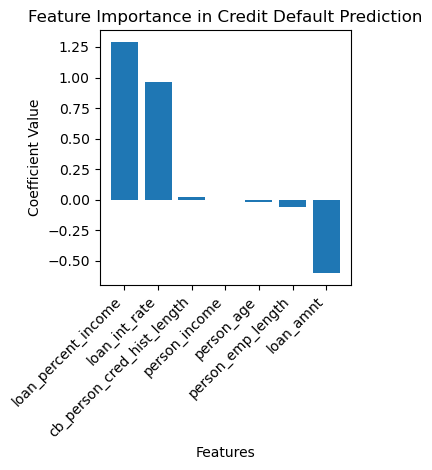

In [24]:
# Bar plot for feature importance
plt.subplot(1, 2, 1)
bars = plt.bar(feature_importance['feature'], feature_importance['coefficient'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Credit Default Prediction')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.tight_layout()

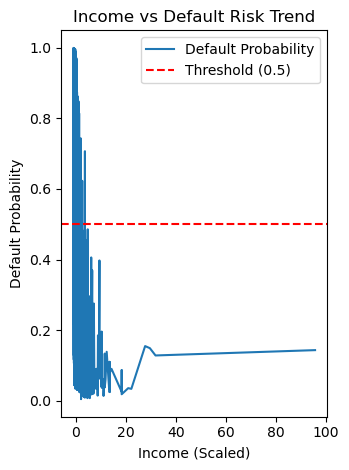

In [25]:
# Plot default risk trend (income vs default probability)
income_col = 'person_income' if 'person_income' in df.columns else 'income'
df['default_prob'] = model.predict_proba(X)[:, 1]  # Probability of default
df_sorted = df.sort_values(income_col)
plt.subplot(1, 2, 2)
plt.plot(df_sorted[income_col], df_sorted['default_prob'], label='Default Probability')
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.xlabel('Income (Scaled)')
plt.ylabel('Default Probability')
plt.title('Income vs Default Risk Trend')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.
